generate conffile

In [2]:
trafficname = "unv1"
multstrarr1 = ["0 2 25","0 17 100","0 1 4","0 17 50"]
multstrarr2 = ["0 21 50","0 51 100","0 59 100","0 34 50","0 38 50","0 17 20"]
multnamearr1 = range(5,21,5)
multnamearr2 = range(25,51,5)
sseedarr = range(1,6)

conffile = f"/home/annzhou/DRing/src/emp/datacentre/experiments/routing/{trafficname}.conf"
make_leafspine = "MAKE"
make_dring = "MAKE"
with open(conffile,'w') as f:
    for imultstr,multstr in enumerate(multstrarr1):
        for sseed in sseedarr:
            multname = multnamearr1[imultstr]
            f.write(f"./run.sh LEAFSPINE {make_leafspine} 80 3072 64 leafspine_{trafficname} NEW_WISC null {multstr} 4 8 0 0 0 0 ecmp 0 {trafficname} {sseed} netpathfiles/netpath_ecmp_leafspine.txt qvarfiles/qvar_leafspine_0_0_ecmp_64 64 50 150 200 0 0 > m_leafspine_{trafficname}_{multname}_{sseed}.log\n")
            make_leafspine = "NOMAKE"
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_{trafficname} NEW_WISC graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 4 8 0 0 0 0 null 0 {trafficname} {sseed} null null 64 50 150 200 0 0 > m_dring_{trafficname}_{multname}_{sseed}.log\n")
            make_dring = "NOMAKE"
    for imultstr,multstr in enumerate(multstrarr2):
        for sseed in sseedarr:
            multname = multnamearr2[imultstr]
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_{trafficname} NEW_WISC graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 4 8 0 0 0 0 null 0 {trafficname} {sseed} null null 64 50 150 200 0 0 > m_dring_{trafficname}_{multname}_{sseed}.log\n")
            make_dring = "NOMAKE"

In [10]:
trafficname = "prv1"
multstrarr1 = ["0 2 100","0 5 100","0 7 100","0 10 100","0 12 100","0 15 100","0 17 100","0 20 100"]
multstrarr2 = ["0 22 100"]
multnamearr1 = range(2,17,2)
multnamearr2 = [18]
sseedarr = range(1,6)

conffile = f"/home/annzhou/DRing/src/emp/datacentre/experiments/routing/{trafficname}.conf"
make_leafspine = "MAKE"
make_dring = "MAKE"
with open(conffile,'w') as f:
    for imultstr,multstr in enumerate(multstrarr1):
        for sseed in sseedarr:
            multname = multnamearr1[imultstr]
            f.write(f"./run.sh LEAFSPINE {make_leafspine} 80 3072 64 leafspine_{trafficname} NEW_WISC null {multstr} 4 8 0 0 0 0 ecmp 0 {trafficname} {sseed} netpathfiles/netpath_ecmp_leafspine.txt qvarfiles/qvar_leafspine_0_0_ecmp_64 64 50 150 200 0 0 > m_leafspine_{trafficname}_{multname}_{sseed}.log\n")
            make_leafspine = "NOMAKE"
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_{trafficname} NEW_WISC graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 4 8 0 0 0 0 null 0 {trafficname} {sseed} null null 64 50 150 200 0 0 > m_dring_{trafficname}_{multname}_{sseed}.log\n")
            make_dring = "NOMAKE"
    for imultstr,multstr in enumerate(multstrarr2):
        for sseed in sseedarr:
            multname = multnamearr2[imultstr]
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_{trafficname} NEW_WISC graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 4 8 0 0 0 0 null 0 {trafficname} {sseed} null null 64 50 150 200 0 0 > m_dring_{trafficname}_{multname}_{sseed}.log\n")
            make_dring = "NOMAKE"

In [1]:
trafficname = "cluster_a"
# multstrarr1 = ["20 42 100","12 25 100","4 8 100","28 59 100"]
# multstrarr2 = ["36 76 100"]
# multnamearr1 = [10,30,50,70]
# multnamearr2 = [90]
multstrarr1 = ["8 17 100","16 34 100","24 51 100"]
multstrarr2 = ["32 67 100"]
multnamearr1 = [20,40,60]
multnamearr2 = [80]
sseedarr = range(1,6)

conffile = f"/home/annzhou/DRing/src/emp/datacentre/experiments/routing/{trafficname}.conf"
make_leafspine = "MAKE"
make_dring = "MAKE"
with open(conffile,'w') as f:
    for imultstr,multstr in enumerate(multstrarr1):
        for sseed in sseedarr:
            multname = multnamearr1[imultstr]
            f.write(f"./run.sh LEAFSPINE {make_leafspine} 80 3072 64 leafspine_{trafficname} NEW_WISC null {multstr} 24 48 0 0 0 0 ecmp 0 {trafficname} {sseed} netpathfiles/netpath_ecmp_leafspine.txt qvarfiles/qvar_leafspine_0_0_ecmp_64 64 50 150 200 0 0 > m_leafspine_{trafficname}_{multname}_{sseed}.log\n")
            make_leafspine = "NOMAKE"
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_{trafficname} NEW_WISC graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 24 48 0 0 0 0 null 0 {trafficname} {sseed} null null 64 50 150 200 0 0 > m_dring_{trafficname}_{multname}_{sseed}.log\n")
            make_dring = "NOMAKE"
    for imultstr,multstr in enumerate(multstrarr2):
        for sseed in sseedarr:
            multname = multnamearr2[imultstr]
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_{trafficname} NEW_WISC graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 24 48 0 0 0 0 null 0 {trafficname} {sseed} null null 64 50 150 200 0 0 > m_dring_{trafficname}_{multname}_{sseed}.log\n")
            make_dring = "NOMAKE"

In [2]:
trafficname = "cluster_b"
multstrarr1 = ["0 53 100","1 7 100","1 60 100","2 14 100"]
multstrarr2 = []
multnamearr1 = [20,40,60,80]
multnamearr2 = []
sseedarr = range(1,6)

conffile = f"/home/annzhou/DRing/src/emp/datacentre/experiments/routing/{trafficname}.conf"
make_leafspine = "MAKE"
make_dring = "MAKE"
with open(conffile,'w') as f:
    for imultstr,multstr in enumerate(multstrarr1):
        for sseed in sseedarr:
            multname = multnamearr1[imultstr]
            f.write(f"./run.sh LEAFSPINE {make_leafspine} 80 3072 64 leafspine_{trafficname} NEW_WISC null {multstr} 24 48 0 0 0 0 ecmp 0 {trafficname} {sseed} netpathfiles/netpath_ecmp_leafspine.txt qvarfiles/qvar_leafspine_0_0_ecmp_64 64 50 150 200 0 0 > m_leafspine_{trafficname}_{multname}_{sseed}.log\n")
            make_leafspine = "NOMAKE"
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_{trafficname} NEW_WISC graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 24 48 0 0 0 0 null 0 {trafficname} {sseed} null null 64 50 150 200 0 0 > m_dring_{trafficname}_{multname}_{sseed}.log\n")
            make_dring = "NOMAKE"
    for imultstr,multstr in enumerate(multstrarr2):
        for sseed in sseedarr:
            multname = multnamearr2[imultstr]
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_{trafficname} NEW_WISC graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 24 48 0 0 0 0 null 0 {trafficname} {sseed} null null 64 50 150 200 0 0 > m_dring_{trafficname}_{multname}_{sseed}.log\n")
            make_dring = "NOMAKE"

In [3]:
trafficname = "cluster_c"
multstrarr1 = ["0 38 100","0 75 100","1 13 100","1 51 100"]
multstrarr2 = []
multnamearr1 = [20,40,60,80]
multnamearr2 = []
sseedarr = range(1,6)

conffile = f"/home/annzhou/DRing/src/emp/datacentre/experiments/routing/{trafficname}.conf"
make_leafspine = "MAKE"
make_dring = "MAKE"
with open(conffile,'w') as f:
    for imultstr,multstr in enumerate(multstrarr1):
        for sseed in sseedarr:
            multname = multnamearr1[imultstr]
            f.write(f"./run.sh LEAFSPINE {make_leafspine} 80 3072 64 leafspine_{trafficname} NEW_WISC null {multstr} 24 48 0 0 0 0 ecmp 0 {trafficname} {sseed} netpathfiles/netpath_ecmp_leafspine.txt qvarfiles/qvar_leafspine_0_0_ecmp_64 64 50 150 200 0 0 > m_leafspine_{trafficname}_{multname}_{sseed}.log\n")
            make_leafspine = "NOMAKE"
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_{trafficname} NEW_WISC graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 24 48 0 0 0 0 null 0 {trafficname} {sseed} null null 64 50 150 200 0 0 > m_dring_{trafficname}_{multname}_{sseed}.log\n")
            make_dring = "NOMAKE"
    for imultstr,multstr in enumerate(multstrarr2):
        for sseed in sseedarr:
            multname = multnamearr2[imultstr]
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_{trafficname} NEW_WISC graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 24 48 0 0 0 0 null 0 {trafficname} {sseed} null null 64 50 150 200 0 0 > m_dring_{trafficname}_{multname}_{sseed}.log\n")
            make_dring = "NOMAKE"

generate sumfile & picklefile

In [ ]:
import pickle

trafficname = "cluster_b"

homedir = "/u/az6922"
datadict = dict()
conffile = f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.conf"
sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.txt"
with open(conffile,'r') as f:
    with open(sumfile,'a') as sumf:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            logfile = tokens[31]
            sizelist = list()
            durationlist = list()
            startlist = list()
            with open(f"{homedir}/DRing/src/emp/datacentre/{logfile}",'r') as logf:
                print(logfile)
                loglines = logf.readlines()
                for logline in loglines:
                    logtokens = logline.split()
                    if logtokens[0] == "FCT":
                        durationlist.append(float(logtokens[2]))
                        sizelist.append(int(logtokens[1]))
                        startlist.append(float(logtokens[3]))
            datadict[logfile] = [durationlist,sizelist,startlist]
            durationlist.sort()
            sumf.write(f"{logfile}\t{sum(durationlist)/len(durationlist)}\t{durationlist[int(len(durationlist)*0.5)]}\t{durationlist[int(len(durationlist)*0.99)]}\t{durationlist[int(len(durationlist)*0.9999)]}\n")

with open(f'{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}_data2.pickle', 'wb') as handle:
    pickle.dump(datadict, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot

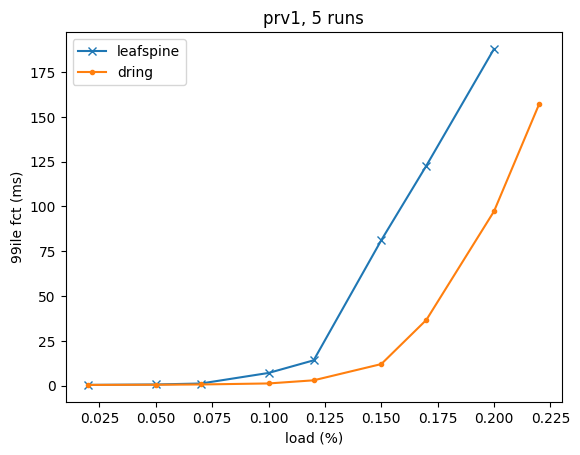

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

trafficname = "prv1"

homedir = "/home/annzhou"
leafspinemultlistarr = [[0,2,100],[0,5,100],[0,7,100],[0,10,100],[0,12,100],[0,15,100],[0,17,100],[0,20,100]]
dringmultlistarr = [[0,2,100],[0,5,100],[0,7,100],[0,10,100],[0,12,100],[0,15,100],[0,17,100],[0,20,100],[0,22,100]]
leafspinemultnamearr = range(2,17,2)
dringmultnamearr = range(2,19,2)
fseedarr = range(5)
sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.txt"

xlist = list()
ylist_over_mult = list()
for imultlist,multlist in enumerate(leafspinemultlistarr):
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    multname = leafspinemultnamearr[imultlist]

    xlist.append(mult + numerator/denominator)

    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_leafspine_{trafficname}_{multname}_{fseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(sum(fct_over_fseed)/len(fct_over_fseed))
plt.plot(xlist,ylist_over_mult,label="leafspine",marker='x')

xlist = list()
ylist_over_mult = list()
for imultlist,multlist in enumerate(dringmultlistarr):
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    multname = dringmultnamearr[imultlist]

    xlist.append(mult + numerator/denominator)

    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_dring_{trafficname}_{multname}_{fseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(sum(fct_over_fseed)/len(fct_over_fseed))
plt.plot(xlist,ylist_over_mult,label="dring",marker='.')

plt.legend()
plt.xlabel('load (%)')
plt.ylabel('99ile fct (ms)')
plt.title(f'{trafficname}, 5 runs')
# plt.ylim(0,20)
plt.savefig(f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.png", dpi=500)
plt.show()

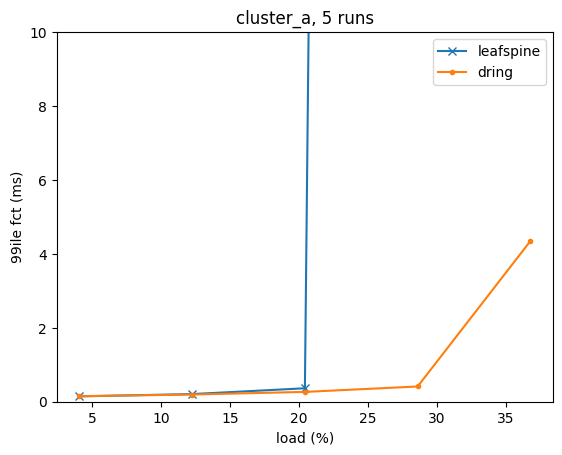

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

trafficname = "cluster_a"

homedir = "/u/az6922"
leafspinemultlistarr = [[4,8,100],[12,25,100],[20,42,100],[28,59,100]]
dringmultlistarr = [[4,8,100],[12,25,100],[20,42,100],[28,59,100],[36,76,100]]
leafspinemultnamearr = [50,30,10,70]
dringmultnamearr = [50,30,10,70,90]
fseedarr = range(1,6)
sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.txt"

xlist = list()
ylist_over_mult = list()
for imultlist,multlist in enumerate(leafspinemultlistarr):
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    multname = leafspinemultnamearr[imultlist]

    xlist.append(mult + numerator/denominator)

    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_leafspine_{trafficname}_{multname}_{fseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(sum(fct_over_fseed)/len(fct_over_fseed))
plt.plot(xlist,ylist_over_mult,label="leafspine",marker='x')

xlist = list()
ylist_over_mult = list()
for imultlist,multlist in enumerate(dringmultlistarr):
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    multname = dringmultnamearr[imultlist]

    xlist.append(mult + numerator/denominator)

    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_dring_{trafficname}_{multname}_{fseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(sum(fct_over_fseed)/len(fct_over_fseed))
plt.plot(xlist,ylist_over_mult,label="dring",marker='.')

plt.legend()
plt.xlabel('load (%)')
plt.ylabel('99ile fct (ms)')
plt.title(f'{trafficname}, 5 runs')
plt.ylim(0,10)
# plt.savefig(f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.png", dpi=500)
plt.show()

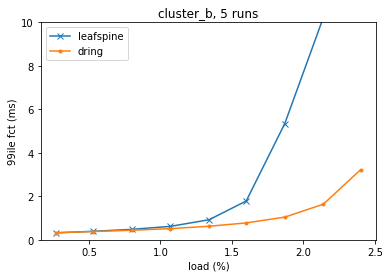

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

trafficname = "cluster_b"

homedir = "/u/az6922"
leafspinemultlistarr = [[0,27,100],[0,53,100],[0,80,100],[1,7,100],[1,34,100],[1,60,100],[1,87,100],[2,14,100],[2,40,100]]
dringmultlistarr = [[0,27,100],[0,53,100],[0,80,100],[1,7,100],[1,34,100],[1,60,100],[1,87,100],[2,14,100],[2,40,100]]
leafspinemultnamearr = range(10,91,10)
dringmultnamearr = range(10,91,10)
fseedarr = range(1,6)
sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.txt"

xlist = list()
ylist_over_mult = list()
for imultlist,multlist in enumerate(leafspinemultlistarr):
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    multname = leafspinemultnamearr[imultlist]

    xlist.append(mult + numerator/denominator)

    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_leafspine_{trafficname}_{multname}_{fseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(sum(fct_over_fseed)/len(fct_over_fseed))
plt.plot(xlist,ylist_over_mult,label="leafspine",marker='x')

xlist = list()
ylist_over_mult = list()
for imultlist,multlist in enumerate(dringmultlistarr):
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    multname = dringmultnamearr[imultlist]

    xlist.append(mult + numerator/denominator)

    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_dring_{trafficname}_{multname}_{fseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(sum(fct_over_fseed)/len(fct_over_fseed))
plt.plot(xlist,ylist_over_mult,label="dring",marker='.')

plt.legend()
plt.xlabel('load (%)')
plt.ylabel('99ile fct (ms)')
plt.title(f'{trafficname}, 5 runs')
plt.ylim(0,10)
# plt.savefig(f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.png", dpi=500)
plt.show()

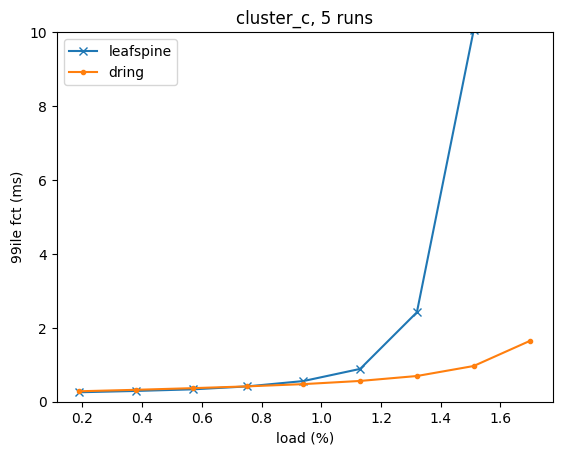

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

trafficname = "cluster_c"

homedir = "/u/az6922"
leafspinemultlistarr = [[0,19,100],[0,38,100],[0,57,100],[0,75,100],[0,94,100],[1,13,100],[1,32,100],[1,51,100],[1,70,100]]
dringmultlistarr = [[0,19,100],[0,38,100],[0,57,100],[0,75,100],[0,94,100],[1,13,100],[1,32,100],[1,51,100],[1,70,100]]
leafspinemultnamearr = range(10,91,10)
dringmultnamearr = range(10,91,10)
fseedarr = range(1,6)
sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.txt"

xlist = list()
ylist_over_mult = list()
for imultlist,multlist in enumerate(leafspinemultlistarr):
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    multname = leafspinemultnamearr[imultlist]

    xlist.append(mult + numerator/denominator)

    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_leafspine_{trafficname}_{multname}_{fseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(sum(fct_over_fseed)/len(fct_over_fseed))
plt.plot(xlist,ylist_over_mult,label="leafspine",marker='x')

xlist = list()
ylist_over_mult = list()
for imultlist,multlist in enumerate(dringmultlistarr):
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    multname = dringmultnamearr[imultlist]

    xlist.append(mult + numerator/denominator)

    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_dring_{trafficname}_{multname}_{fseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(sum(fct_over_fseed)/len(fct_over_fseed))
plt.plot(xlist,ylist_over_mult,label="dring",marker='.')

plt.legend()
plt.xlabel('load (%)')
plt.ylabel('99ile fct (ms)')
plt.title(f'{trafficname}, 5 runs')
plt.ylim(0,10)
# plt.savefig(f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.png", dpi=500)
plt.show()

delete log,run files

In [ ]:
import os

homedir = "/u/az6922"
dringdir = f"{homedir}/DRing/src/emp/datacentre"
for filedir in os.listdir(dringdir):
    if os.path.isfile(os.path.join(dringdir, filedir)):
        tokens = filedir.split("_")
        if tokens[0]=="m" and (tokens[1]=="leafspine" or tokens[1]=="dring") and tokens[-1].split('.')[-1]=="log":
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")
        if (tokens[0]=="rrg" or tokens[0]=="leafspine") and tokens[1]=="log":
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")
        if (tokens[-1]=="run") and ((tokens[0]=="leafspine" and tokens[1]=="leafspine") or (tokens[0]=="rrg" and (tokens[1]=="rrg" or tokens[1]=="dring"))):
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")